# 트랜잭션 분류를 위한 클러스터링

이 노트북에서는 데이터에 레이블이 없지만 의미 있는 카테고리로 클러스터링하는 데 사용할 수 있는 기능이 있는 사용 사례를 다룹니다. 클러스터링의 과제는 이러한 클러스터를 눈에 띄게 만드는 특징을 사람이 읽을 수 있게 만드는 것입니다. 바로 이 부분에서 GPT-3을 사용해 의미 있는 클러스터 설명을 생성하는 방법을 살펴볼 것입니다. 그런 다음 이를 사용하여 이전에 레이블이 지정되지 않은 데이터 집합에 레이블을 적용할 수 있습니다.

모델에 공급하기 위해 노트북 [트랜잭션에 대한 다중 클래스 분류 노트북](Multiclass_classification_for_transactions.ipynb)에 표시된 접근 방식을 사용하여 만든 임베딩을 사용하여 데이터 세트의 전체 359개 트랜잭션에 적용하여 학습을 위한 더 큰 풀을 제공합니다.

## Setup

In [1]:
# imports
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import os

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-003"
# COMPLETIONS_MODEL = "text-davinci-002"


# This path leads to a file with data and precomputed embeddings
embedding_path = "data/library_transactions_with_embeddings_359.csv"


## Clustering

[클러스터링 노트북](Clustering.ipynb)의 접근 방식을 재사용하여, 이전에 만든 기능 임베딩을 사용하여 데이터 집합을 클러스터링하기 위해 K-Means를 사용하겠습니다. 그런 다음 Completions 엔드포인트를 사용하여 클러스터 설명을 생성하고 그 효과를 판단합니다.

We'll reuse the approach from the [Clustering Notebook](Clustering.ipynb), using K-Means to cluster our dataset using the feature embeddings we created previously. We'll then use the Completions endpoint to generate cluster descriptions for us and judge their effectiveness

In [2]:
df = pd.read_csv(embedding_path)

In [3]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["embedding"] = embedding_df.embedding.apply(eval).apply(np.array)
matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(359, 1536)

In [4]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

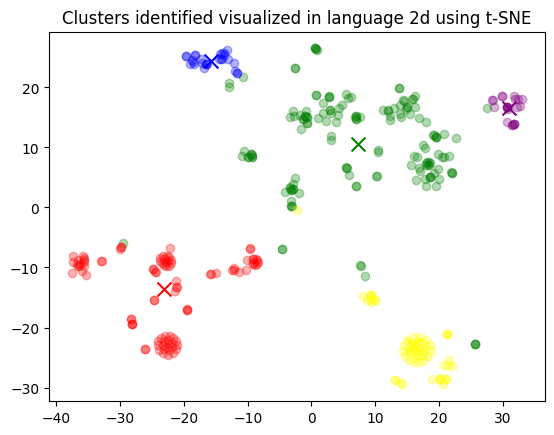

In [5]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [9]:
# We'll read 10 transactions per cluster as we're expecting some variation
transactions_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    transactions = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined.str.replace("Supplier: ", "")
        .str.replace("Description: ", ":  ")
        .str.replace("Value: ", ":  ")
        .sample(transactions_per_cluster, random_state=42)
        .values
    )
    print("\n\nPrompt:" )
    print("." * 100)
    print(f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. What do the following transactions have in common? Could you make your response in Korean? \n\nTransactions:\n"""\n{transactions[:70]}\n"""\n\nTheme:''')
    print("." * 100)
    response = openai.Completion.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        prompt=f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. What do the following transactions have in common? Could you make your response in Korean? \n\nTransactions:\n"""\n{transactions}\n"""\n\nTheme:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print("\n\nResponse:" )
    print("." * 100)
    print(response["choices"][0]["text"].replace("\n", ""))
    print("." * 100)

    print("\n\nSamples:" )
    print("." * 100)

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    for j in range(transactions_per_cluster):
        print(sample_cluster_rows.Supplier.values[j], end=", ")
        print(sample_cluster_rows.Description.values[j], end="\n")
        #print(str(sample_cluster_rows.Value).values[j])
    print("." * 100)

    print("-" * 100)


Cluster 0 Theme: 

Prompt:
....................................................................................................
We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. What do the following transactions have in common? Could you make your response in Korean? 

Transactions:
"""
ALDL; :  ALDL Charges; :  0       35098.00
1       30000.00
2       40
"""

Theme:
....................................................................................................


Response:
....................................................................................................
 모든 거래는 ALDL 또는 British Library에서 제공하는 법적 예치금 서비스에 관한 것입니다. 각 거래
....................................................................................................


Samples:
....................................................................................................
ALDL, ALDL Charges
Agency for Legal Deposit Libaries, Agency servi

### 결론

이제 데이터를 설명하는 데 사용할 수 있는 5개의 새로운 클러스터가 생겼습니다. 비주얼리제이션을 보면 일부 클러스터가 겹치는 부분이 있고 올바른 위치에 도달하려면 약간의 조정이 필요하지만, 이미 GPT-3이 몇 가지 효과적인 추론을 해냈다는 것을 알 수 있습니다. 특히, 법적 예치금을 포함한 항목이 문헌 보관과 관련이 있다는 것을 포착했는데, 이는 사실이지만 모델에 단서가 주어지지 않았던 것입니다. 매우 멋진 결과이며, 약간의 튜닝을 통해 멀티클래스 분류기와 함께 사용할 수 있는 기본 클러스터 집합을 만들어 다른 트랜잭션 데이터 세트에 일반화할 수 있습니다.

We now have five new clusters that we can use to describe our data. Looking at the visualisation some of our clusters have some overlap and we'll need some tuning to get to the right place, but already we can see that GPT-3 has made some effective inferences. In particular, it picked up that items including legal deposits were related to literature archival, which is true but the model was given no clues on. Very cool, and with some tuning we can create a base set of clusters that we can then use with a multiclass classifier to generalise to other transactional datasets we might use.